# Paper IEEE Access (Quali) - Análise de Resultados Geral
---
Avaliação sistemática dos resultados obtidos considerando a hipóptese de adoção de gráfico de recorrência para o problema de classificação de séries temporais no contexto de NILM. 

Foram avaliadas 3 métodos:

1. Atributos RQA + classificadores rasos (abordagens tradicionais Machine Learning);
2. Atributos extraídos via Deep Learning + classificadores rasos;
3. Classificação via Deep Learning (abordagem CNN end-to-end).

# Configurações e Dados

In [1]:
import os
import sys
import gc
from pprint import pprint
from collections import Counter
import copy
import warnings
warnings.filterwarnings(action="ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
# matplotlib.style.use('ggplot')
from matplotlib import pyplot as plt
from IPython.display import display

from tqdm import *
from glob import glob

# Path do arquivo H5 (base REDD ja preparada p/ NILMTK) e outros insumos fundamentais
caminho_dados = "D:/Projetos/phd-thesis/datasets/"

# Definir diretorios onde iremos salvar os insumos gerados do notebook (dados, imagens, etc.)
caminho_dados_notebook = os.path.join(caminho_dados, "24") # Num. notebook
if not os.path.isdir(caminho_dados_notebook):
    os.makedirs(caminho_dados_notebook)
    
caminho_imagens_notebook = os.path.join(caminho_dados_notebook, "imagens") # Num. notebook
if not os.path.isdir(caminho_imagens_notebook):
    os.makedirs(caminho_imagens_notebook)

In [7]:
datasets = []

# Resultados abordagem 1 (RQA + Machine Learning)
for arquivo in glob(os.path.join(caminho_dados, "22/df_resultados_*.xlsx")):
    df_ = pd.read_excel(arquivo, index_col=0, engine="openpyxl")
    df_["method"] = "RQA+"+arquivo.split("\\")[-1].split('.xlsx')[0].split('_')[-1].upper()
    datasets.append(df_)

# Resultados abordagem 2 (RP DeepLearning Automatic Feature Extraction + Machine Learning)
for arquivo in glob(os.path.join(caminho_dados, "23/df_resultados_*.xlsx")):
    df_ = pd.read_excel(arquivo, index_col=0, engine="openpyxl")
    df_["method"] = "DTLFE+"+arquivo.split("\\")[-1].split('.xlsx')[0].split('_')[-1].upper()
    datasets.append(df_)

# TODO: Incluir CNN
# Resultados abordagem 3 (end-to-end CNN)
df_ = pd.read_excel(
    os.path.join(caminho_dados, "20/residencia_3/resultados_baseline.xlsx"),
    engine="openpyxl"
).rename(columns={
    'aparelho': 'appliance',
    'teste': 'test',
    'acuracia': 'acc',
    'iteracao': 'iteration',
    'metodologia': 'method'
})
df_ = df_.query("test==1 or base=='teste'") # Selecionando apenas 1 rodada de teste
del df_["test"]
df_["method"] = "RP+CNN"
datasets.append(df_)

# Dataframe com todos resultados
df = pd.concat(datasets)

# Análises

In [8]:
colors = ['#00BA38', '#598BDF', '#F8766D']

## Estatísticas gerais

In [9]:
df['feature'] = df['method'].apply(lambda m: m.split('+')[0])

In [10]:
print("* Análise por extracao de atributos:")
df_analise_feature = df[df["base"]=="teste"].groupby(["feature","base"]).agg({
    "acc": ["median","std","max","min"],
    "f1": ["median","std","max","min"],
    "auc": ["median","std","max","min"]
}).reset_index().sort_values(('f1','median'), ascending=False).set_index("feature")
display(df_analise_feature)
df_analise_feature.to_excel(os.path.join(caminho_dados_notebook, "df_analise_feature.xlsx"))
print()


print("* Análise por metodologia:")
df_analise_metodo = df[df["base"]=="teste"].groupby(["method","base"]).agg({
    "acc": ["median","std","max","min"],
    "f1": ["median","std","max","min"],
    "auc": ["median","std","max","min"]
}).reset_index().sort_values(('f1','median'), ascending=False).set_index("method")
display(df_analise_metodo)
df_analise_metodo.to_excel(os.path.join(caminho_dados_notebook, "df_analise_metodo.xlsx"))

print()
print("* Análise por aparelho/metodologia:")
df_analise_aparelho = df[df["base"]=="teste"].groupby(["appliance","method","base"]).agg({
    "acc": ["median","std","max","min"],
    "f1": ["median","std","max","min"],
    "auc": ["median","std","max","min"]
}).sort_values(["appliance",('f1','median')],ascending=[True,False])
display(df_analise_aparelho)
df_analise_aparelho.to_excel(os.path.join(caminho_dados_notebook, "df_analise_aparelho.xlsx"))

* Análise por extracao de atributos:


base       acc                                      f1            \
                  median       std       max       min    median       std   
feature                                                                      
DTLFE    teste  0.981752  0.013767  0.997725  0.953988  0.803751  0.197501   
RP       teste  0.955720  0.016859  0.985401  0.929448  0.704138  0.084699   
RQA      teste  0.960290  0.020061  0.981752  0.917178  0.491905  0.061984   

                                  auc                                
              max       min    median       std       max       min  
feature                                                              
DTLFE    0.984742  0.491905  0.768464  0.189182  0.976024  0.500000  
RP       0.775569  0.535669  0.653019  0.071480  0.743191  0.529601  
RQA      0.717584  0.484177  0.500000  0.051947  0.696283  0.498734


* Análise por metodologia:


base       acc                                      f1  \
                        median       std       max       min    median   
method                                                                   
DTLFE+MLP      teste  0.969136  0.011760  0.991934  0.963190  0.813821   
DTLFE+XGBOOST  teste  0.981752  0.015062  0.997725  0.960123  0.803751   
RP+CNN         teste  0.955720  0.016859  0.985401  0.929448  0.704138   
DTLFE+SVM      teste  0.981752  0.016924  0.997104  0.953988  0.688038   
RQA+XGBOOST    teste  0.959876  0.026408  0.981752  0.917178  0.504757   
RQA+MLP        teste  0.960290  0.018333  0.981752  0.938650  0.489871   
RQA+SVM        teste  0.960290  0.018333  0.981752  0.938650  0.489871   

                                                  auc                      \
                    std       max       min    median       std       max   
method                                                                      
DTLFE+MLP      0.156339  0.946178  0.558552  0.768865  0.158763  0.938381   
DTLFE+XGBOOST  0.237037  0.984742  0.491905  0.768464  0.220349  0.973851   
RP+CNN         0.084699  0.775569  0.535669  0.653019  0.071480  0.743191   
DTLFE+SVM      0.234460  0.980825  0.491905  0.625000  0.225873  0.976024   
RQA+XGBOOST    0.038619  0.581935  0.491272  0.507274  0.027837  0.563074   
RQA+MLP        0.004779  0.495396  0.484177  0.500000  0.000000  0.500000   
RQA+SVM        0.102873  0.717584  0.484177  0.500000  0.087780  0.696283   

                         
                    min  
method                   
DTLFE+MLP      0.537196  
DTLFE+XGBOOST  0.500000  
RP+CNN         0.529601  
DTLFE+SVM      0.500000  
RQA+XGBOOST    0.498734  
RQA+MLP        0.500000  
RQA+SVM        0.500000


* Análise por aparelho/metodologia:


acc                                \
                                         median       std       max       min   
appliance         method        base                                            
dish_washer - 9   DTLFE+MLP     teste  0.968137       NaN  0.968137  0.968137   
                  RP+CNN        teste  0.953431       NaN  0.953431  0.953431   
                  DTLFE+SVM     teste  0.968137       NaN  0.968137  0.968137   
                  DTLFE+XGBOOST teste  0.968137       NaN  0.968137  0.968137   
                  RQA+MLP       teste  0.968137       NaN  0.968137  0.968137   
                  RQA+SVM       teste  0.968137       NaN  0.968137  0.968137   
                  RQA+XGBOOST   teste  0.965686       NaN  0.965686  0.965686   
fridge - 7        RP+CNN        teste  0.985401       NaN  0.985401  0.985401   
                  RQA+SVM       teste  0.981752       NaN  0.981752  0.981752   
                  DTLFE+MLP     teste  0.981752       NaN  0.981752  0.981752   
                  DTLFE+SVM     teste  0.981752       NaN  0.981752  0.981752   
                  DTLFE+XGBOOST teste  0.981752       NaN  0.981752  0.981752   
                  RQA+MLP       teste  0.981752       NaN  0.981752  0.981752   
                  RQA+XGBOOST   teste  0.981752       NaN  0.981752  0.981752   
microwave - 16    DTLFE+MLP     teste  0.963190       NaN  0.963190  0.963190   
                  DTLFE+XGBOOST teste  0.960123       NaN  0.960123  0.960123   
                  DTLFE+SVM     teste  0.953988       NaN  0.953988  0.953988   
                  RP+CNN        teste  0.929448       NaN  0.929448  0.929448   
                  RQA+XGBOOST   teste  0.917178       NaN  0.917178  0.917178   
                  RQA+MLP       teste  0.938650       NaN  0.938650  0.938650   
                  RQA+SVM       teste  0.938650       NaN  0.938650  0.938650   
washer_dryer - 13 DTLFE+XGBOOST teste  0.997725       NaN  0.997725  0.997725   
                  DTLFE+SVM     teste  0.997104       NaN  0.997104  0.997104   
                  DTLFE+MLP     teste  0.991934       NaN  0.991934  0.991934   
                  RP+CNN        teste  0.959462  0.009945  0.966494  0.952430   
                  RQA+XGBOOST   teste  0.959876       NaN  0.959876  0.959876   
                  RQA+MLP       teste  0.960290       NaN  0.960290  0.960290   
                  RQA+SVM       teste  0.960290       NaN  0.960290  0.960290   
washer_dryer - 14 DTLFE+SVM     teste  0.987654       NaN  0.987654  0.987654   
                  DTLFE+XGBOOST teste  0.987654       NaN  0.987654  0.987654   
                  DTLFE+MLP     teste  0.969136       NaN  0.969136  0.969136   
                  RP+CNN        teste  0.958487  0.003914  0.961255  0.955720   
                  RQA+XGBOOST   teste  0.930864       NaN  0.930864  0.930864   
                  RQA+MLP       teste  0.940741       NaN  0.940741  0.940741   
                  RQA+SVM       teste  0.940741       NaN  0.940741  0.940741   

                                             f1                                \
                                         median       std       max       min   
appliance         method        base                                            
dish_washer - 9   DTLFE+MLP     teste  0.558552       NaN  0.558552  0.558552   
                  RP+CNN        teste  0.535669       NaN  0.535669  0.535669   
                  DTLFE+SVM     teste  0.491905       NaN  0.491905  0.491905   
                  DTLFE+XGBOOST teste  0.491905       NaN  0.491905  0.491905   
                  RQA+MLP       teste  0.491905       NaN  0.491905  0.491905   
                  RQA+SVM       teste  0.491905       NaN  0.491905  0.491905   
                  RQA+XGBOOST   teste  0.491272       NaN  0.491272  0.491272   
fridge - 7        RP+CNN        teste  0.746296       NaN  0.746296  0.746296   
                  RQA+SVM       teste  0.717584       NaN  0.717584  0.717

## Comparativo entre metodologias - RQA vs. DTLFE

In [52]:
# libraries
import seaborn as sns

matplotlib.style.use('default')
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.color'] = 'gray'
matplotlib.rcParams['grid.linestyle'] = '-'
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['grid.alpha'] = .5
sns.set(font_scale=1.8, style=None, palette=None)

def order_values_plot(df, column, values):
    key = df[column].map({v: i for i, v in enumerate(values)}) # df_avg['feature'].unique().tolist()
    return df.iloc[key.argsort()]


In [53]:
# matplotlib.rcParams.keys()

### Desempenho Médio Geral

Metodologias - Desempenho Médio Geral (base = treino)


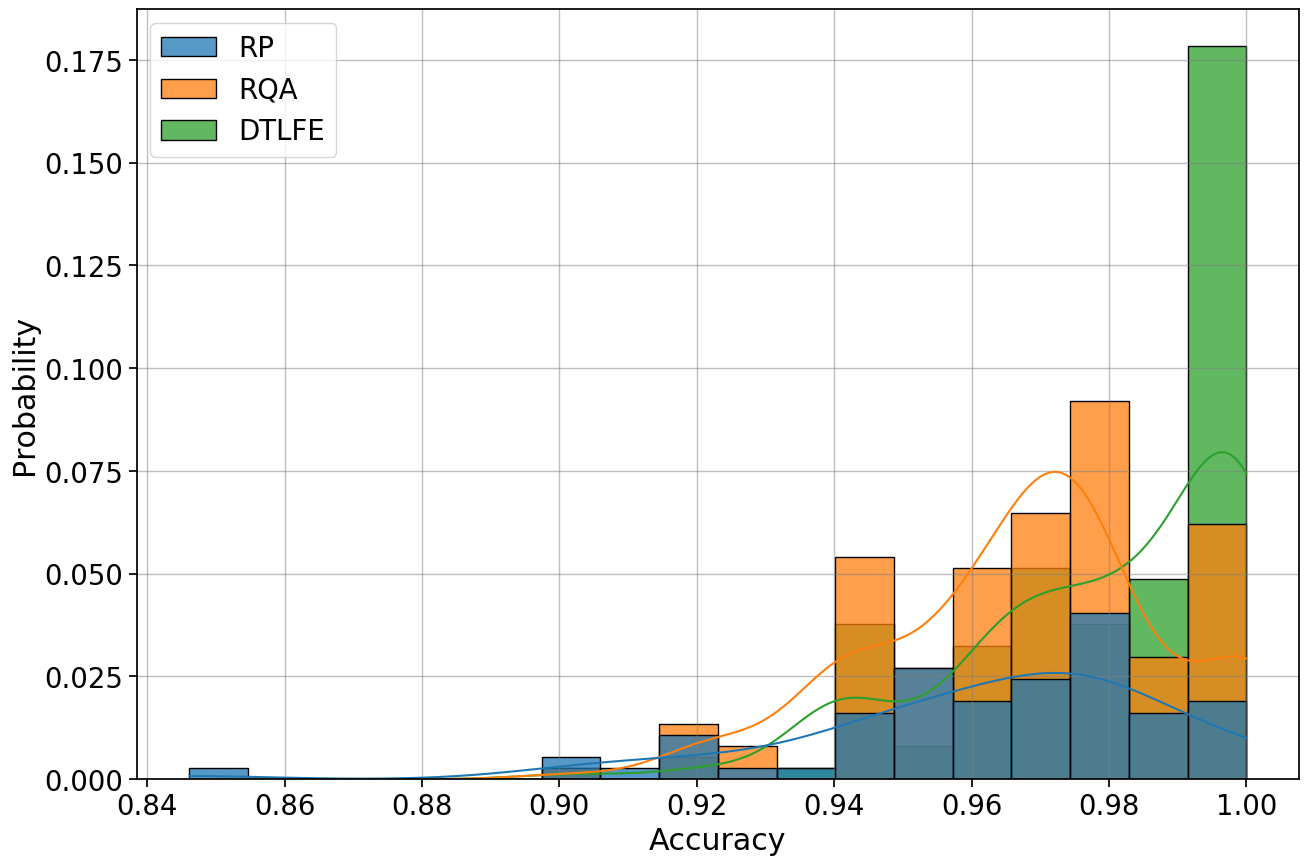

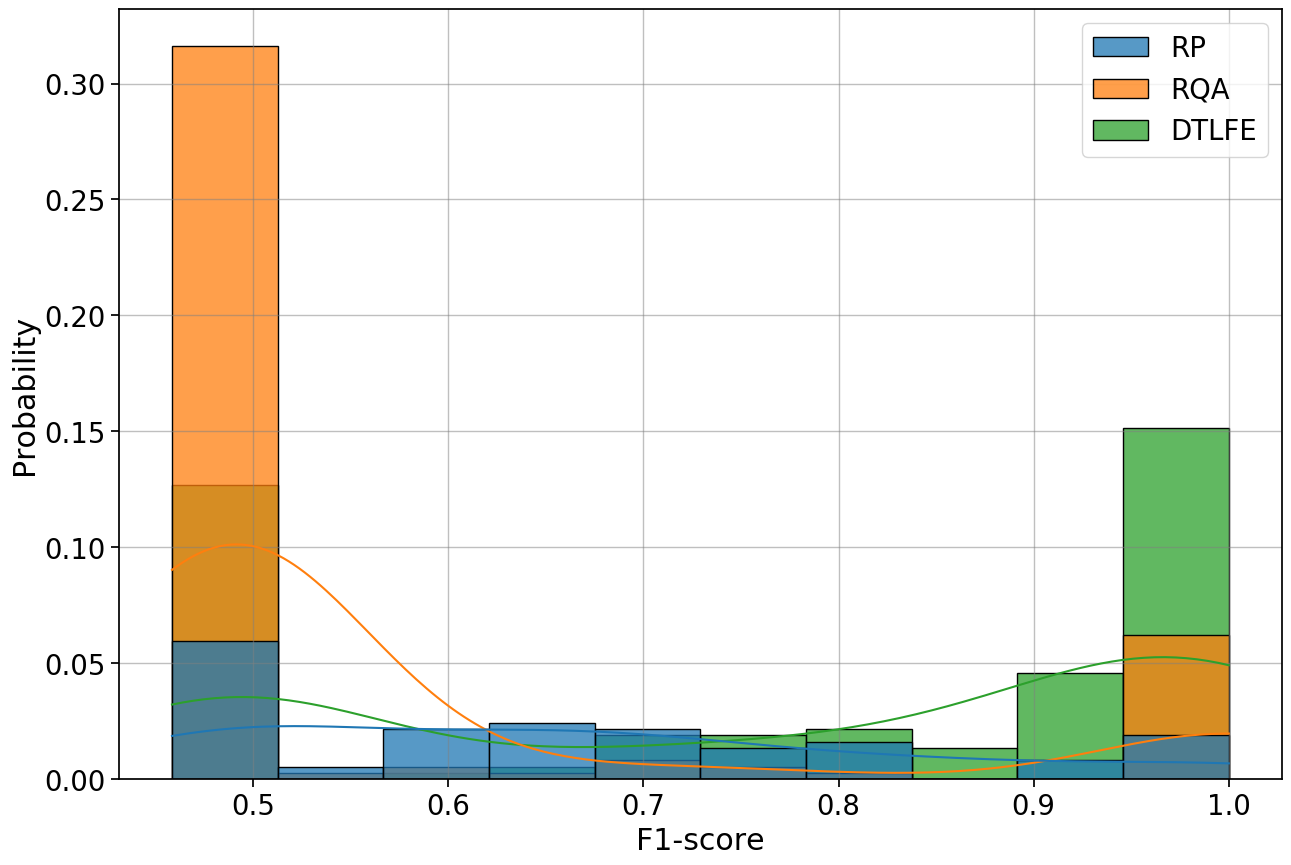

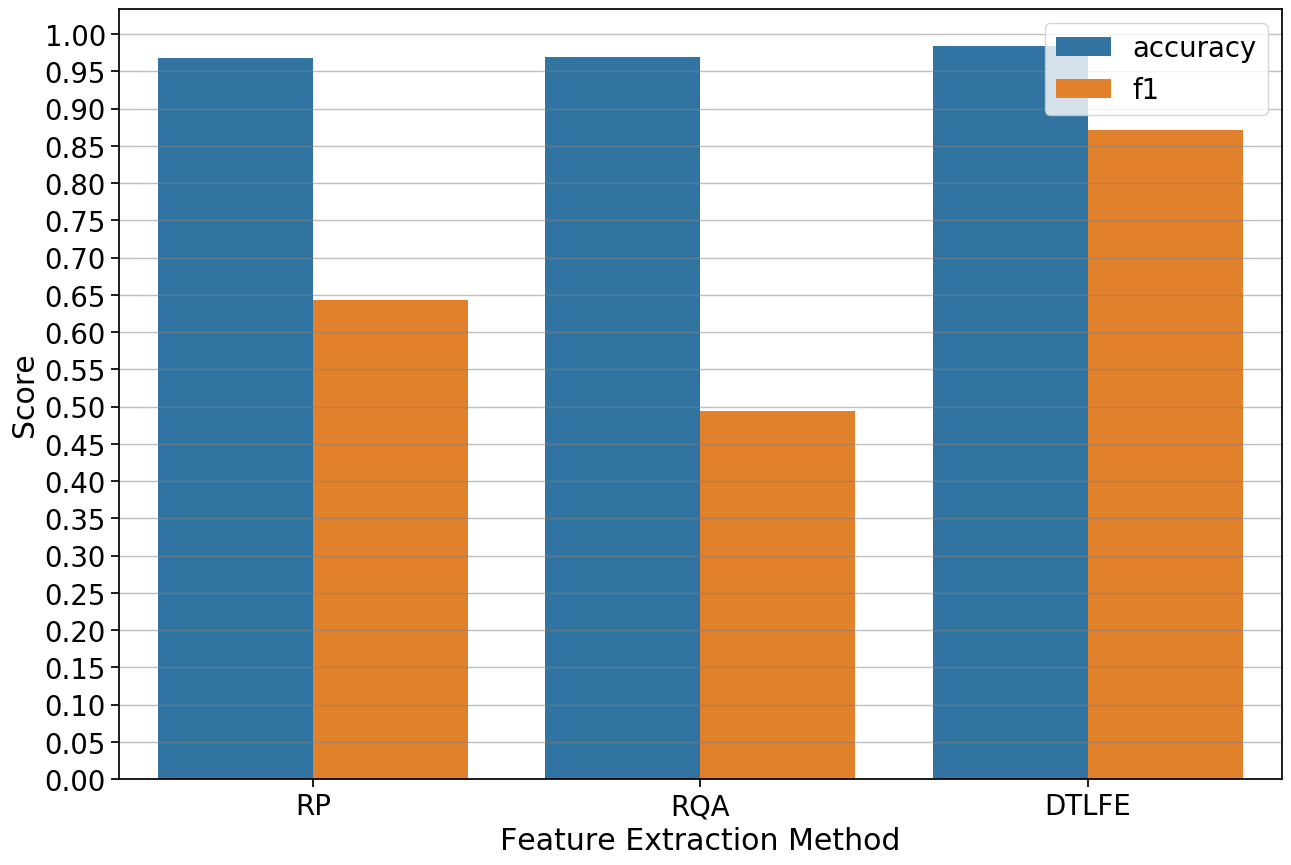

Metodologias - Desempenho Médio Geral (base = teste)


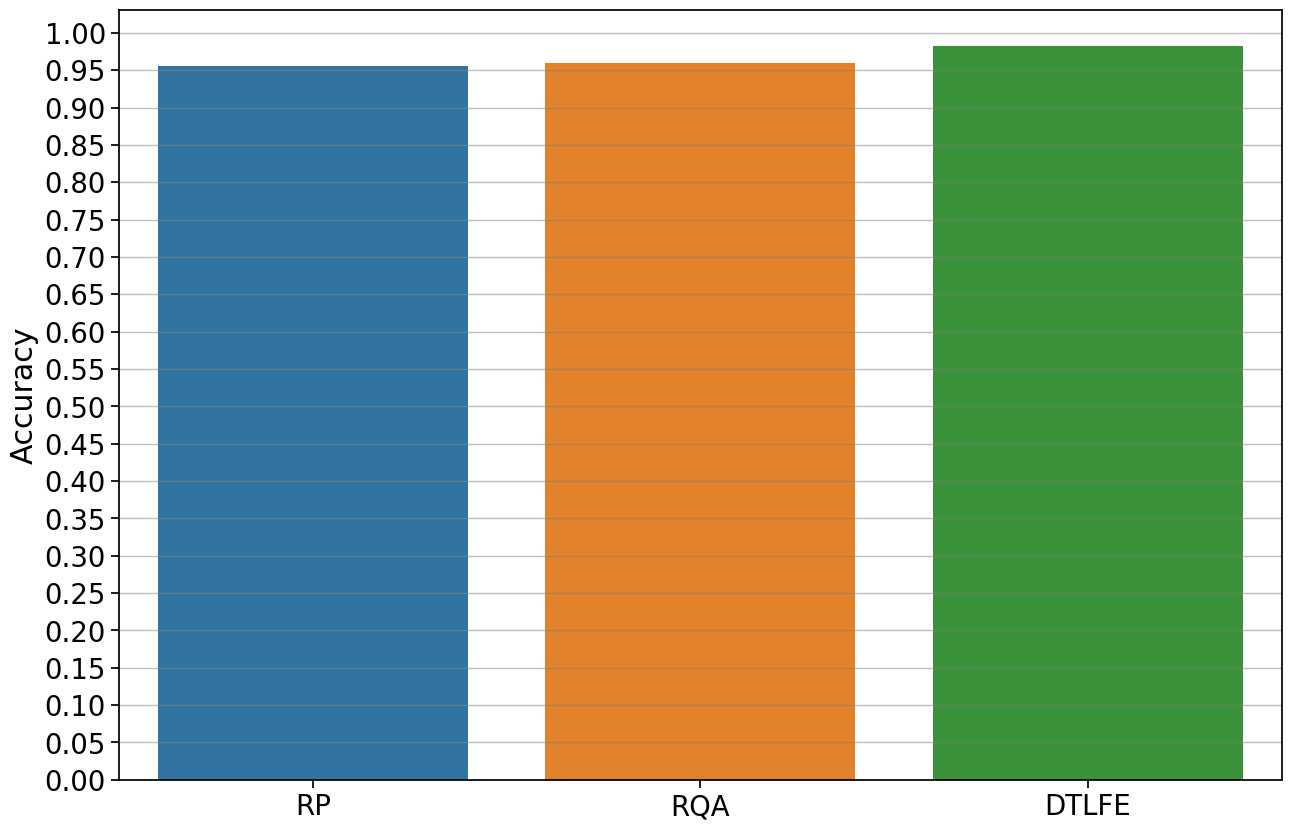

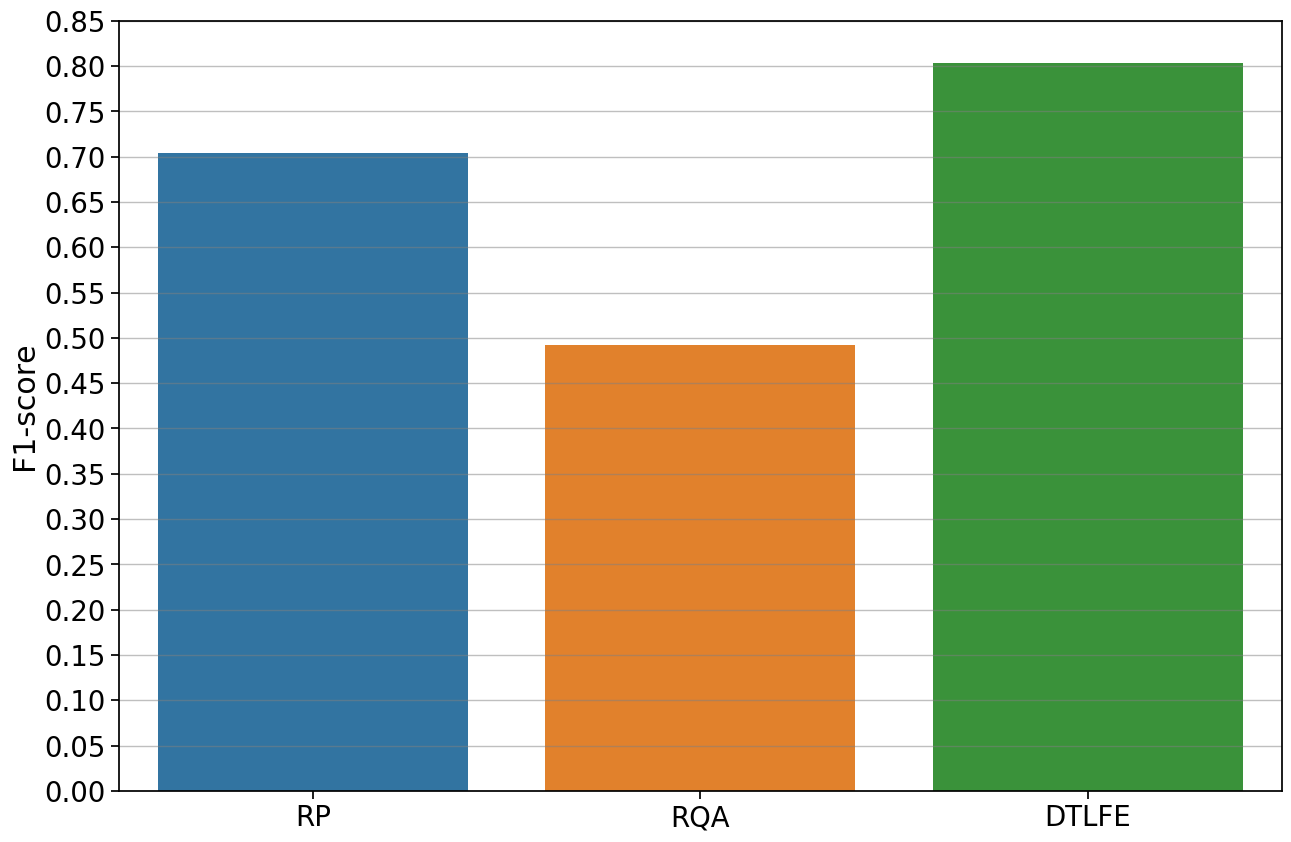

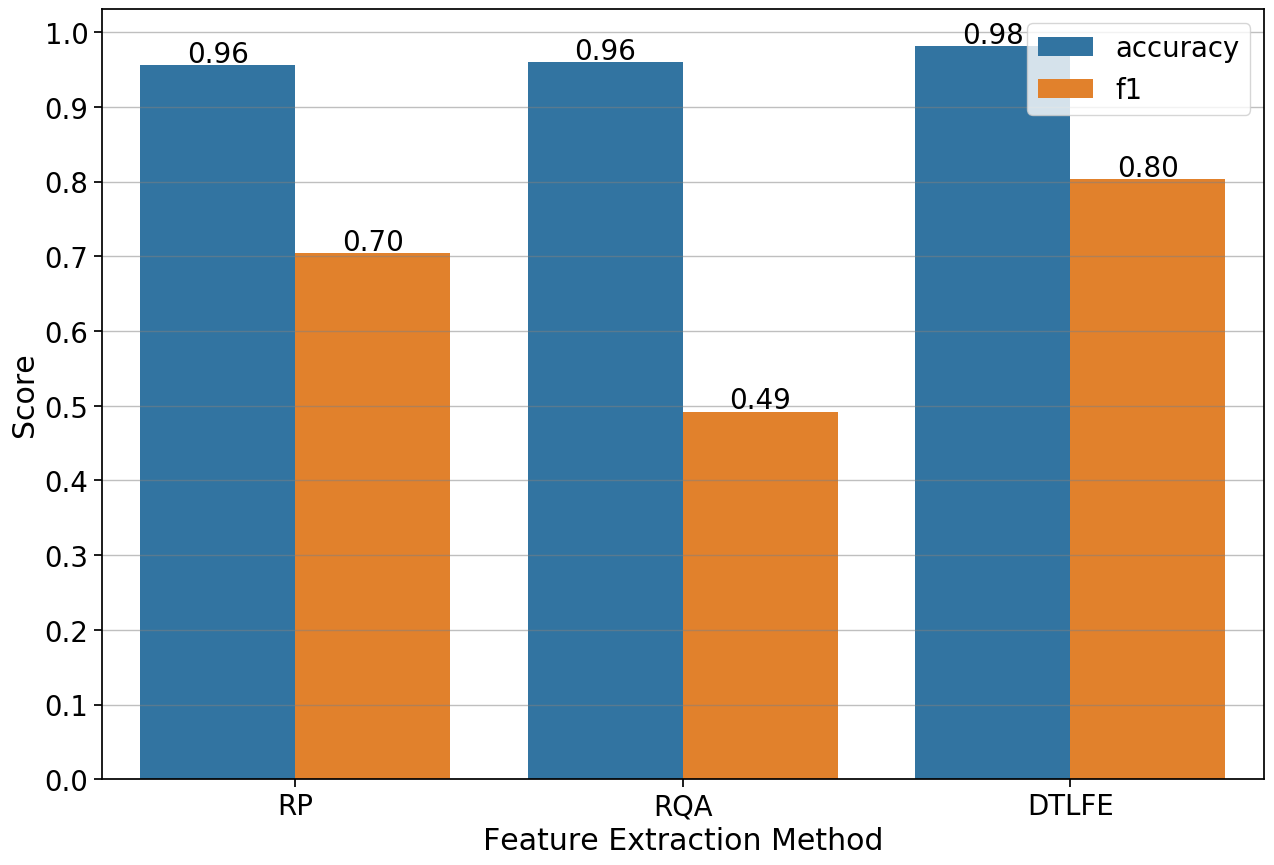

In [88]:
for b in ['treino','teste']:
    df_ = df.query(f"base == '{b}'").reset_index()
    
    df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
    df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 
    
    # Ordenar grafico por atributo
    df_ = order_values_plot(df_, column='feature', values=['RP','RQA','DTLFE'])
    
    # fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20,6))
    print(f'Metodologias - Desempenho Médio Geral (base = {b})')
    if b == 'treino':
        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.histplot(
            df_, x="acc", hue="feature", 
            stat="probability", kde=True,
            ax=ax, 
            alpha=.75,
            # palette=colors
        )
        g.legend_.set_title(None)
        ax.set_xlabel('Accuracy')
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_treino_acuracia.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
        
        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.histplot(
            df_, x="f1", hue="feature", 
            stat="probability", kde=True,
            ax=ax, 
            alpha=.75,
            # palette=colors
        )
        g.legend_.set_title(None)
        ax.set_xlabel('F1-score')
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_treino_f1.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
        # Data
        df_avg = df_.groupby('feature').agg({'f1':{'median'}, 'acc': {'median'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        rows = []
        for _, r in df_avg.iterrows():
            rows.append({
                'feature': r['feature'],
                'metric': 'accuracy',
                'value': r['acc']
            })
            rows.append({
                'feature': r['feature'],
                'metric': 'f1',
                'value': r['f1']
            })
        df_avg = pd.DataFrame(rows)

        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.barplot(x="feature", y="value", hue="metric", data=df_avg)
        g.legend_.set_title(None)
        ax.set(
            title='', 
            ylabel='Score', xlabel='Feature Extraction Method',            
            #xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['value'])+.05, .05)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_treino.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
    else:
        
        # Buscar o valor MODA
        
        df_avg = df_.groupby('feature').agg({'acc':{'median'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        # Plot
        fig, ax = plt.subplots(figsize=(15,10))
        sns.barplot(x="feature", y="acc", data=df_avg, ax=ax)
        ax.set(
            title='', 
            xlabel='', ylabel='Accuracy',            
            xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['acc'])+.05, .05)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_teste_acuracia.png',
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )

        df_avg = df_.groupby('feature').agg({'f1':{'median'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        # Plot
        fig, ax = plt.subplots(figsize=(15,10))
        sns.barplot(x="feature", y="f1", data=df_avg, ax=ax)
        ax.set(
            title='', 
            xlabel='', ylabel='F1-score',            
            xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['f1'])+.05, .05)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_teste_f1.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )

        # Data
        df_avg = df_.groupby('feature').agg({'f1':{'median'}, 'acc': {'median'}}).reset_index(drop=False)
        df_avg.columns = df_avg.columns.get_level_values(0)
        # Order
        df_avg = order_values_plot(df_avg, column='feature', values=['RP','RQA','DTLFE'])
        rows = []
        for _, r in df_avg.iterrows():
            rows.append({
                'feature': r['feature'],
                'metric': 'accuracy',
                'value': r['acc']
            })
            rows.append({
                'feature': r['feature'],
                'metric': 'f1',
                'value': r['f1']
            })
        df_avg = pd.DataFrame(rows)

        fig, ax = plt.subplots(figsize=(15,10))
        g=sns.barplot(x="feature", y="value", hue="metric", data=df_avg)
        # Remove legend title
        g.legend_.set_title(None) 
        # Inserting metrics over the bars
        for bar in g.patches:
            g.annotate(format(bar.get_height(), '.2f'), 
            (bar.get_x() + bar.get_width() / 2, 
            bar.get_height()), ha='center', va='center',
            size=20, xytext=(0, 8),
            textcoords='offset points')
        ax.set(
            title='', 
            ylabel='Score', xlabel='Feature Extraction Method',            
            # #xticklabels=df_avg['feature'],
            yticks=np.arange(0, np.max(df_avg['value'])+.1, .1)  
        );
        plt.show()
        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                '1_geral_teste.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
    # plt.suptitle(f'Metodologias - Desempenho Médio Geral (base = {b})', size=18);
    # # plt.tight_layout();
    # plt.show();

### Comparação de Desempenho dos Classificadores de ML

RQA vs. DLAFE (base de treino) - Comparativo de Classificadores


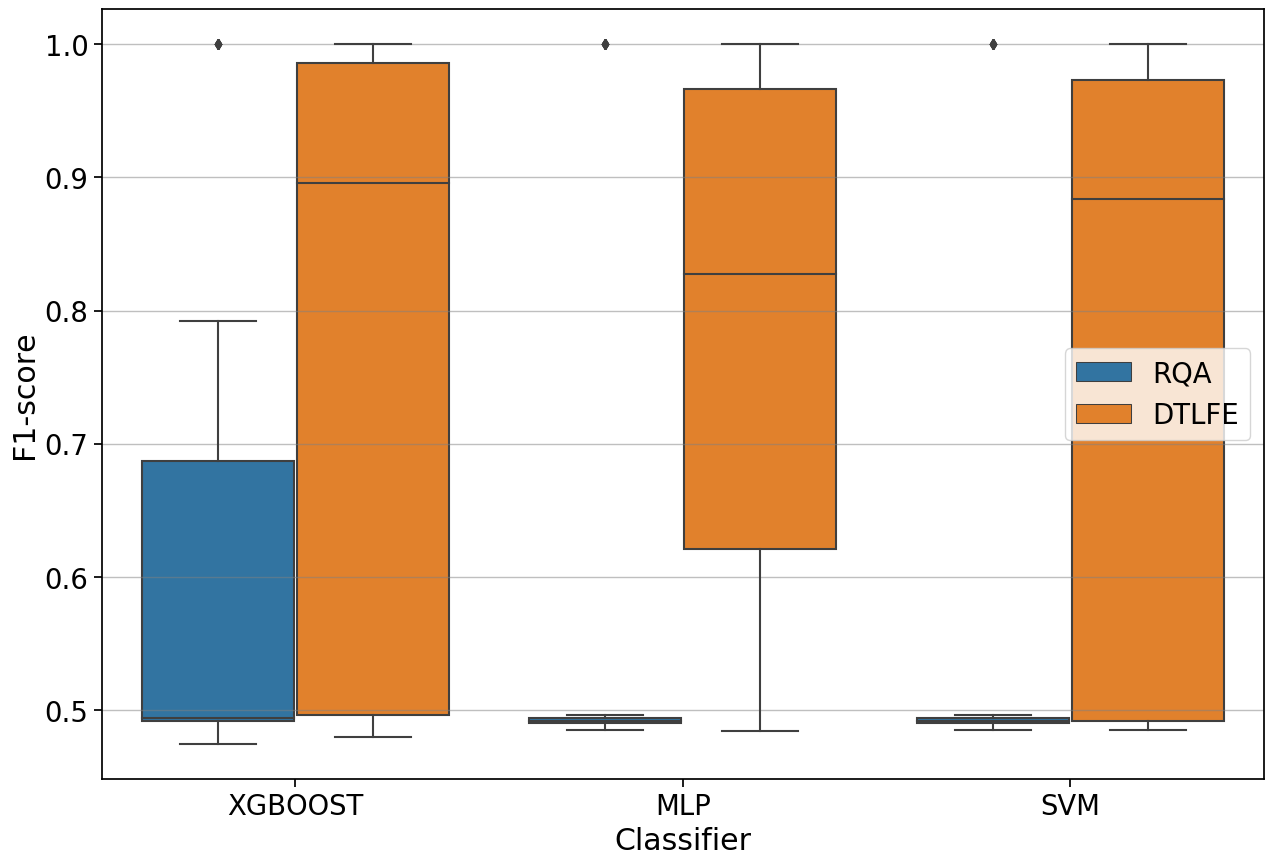

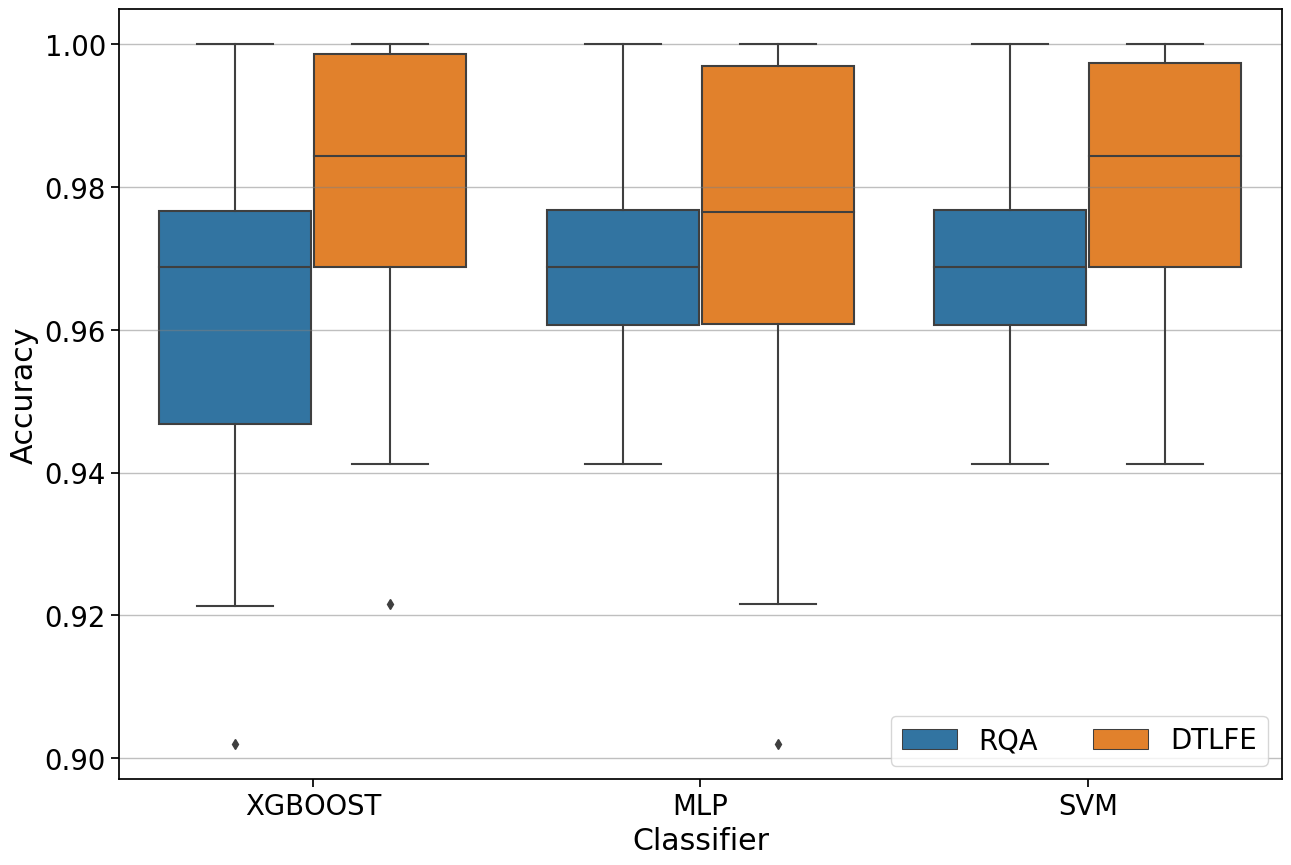

RQA vs. DLAFE (base de teste) - Comparativo de Classificadores


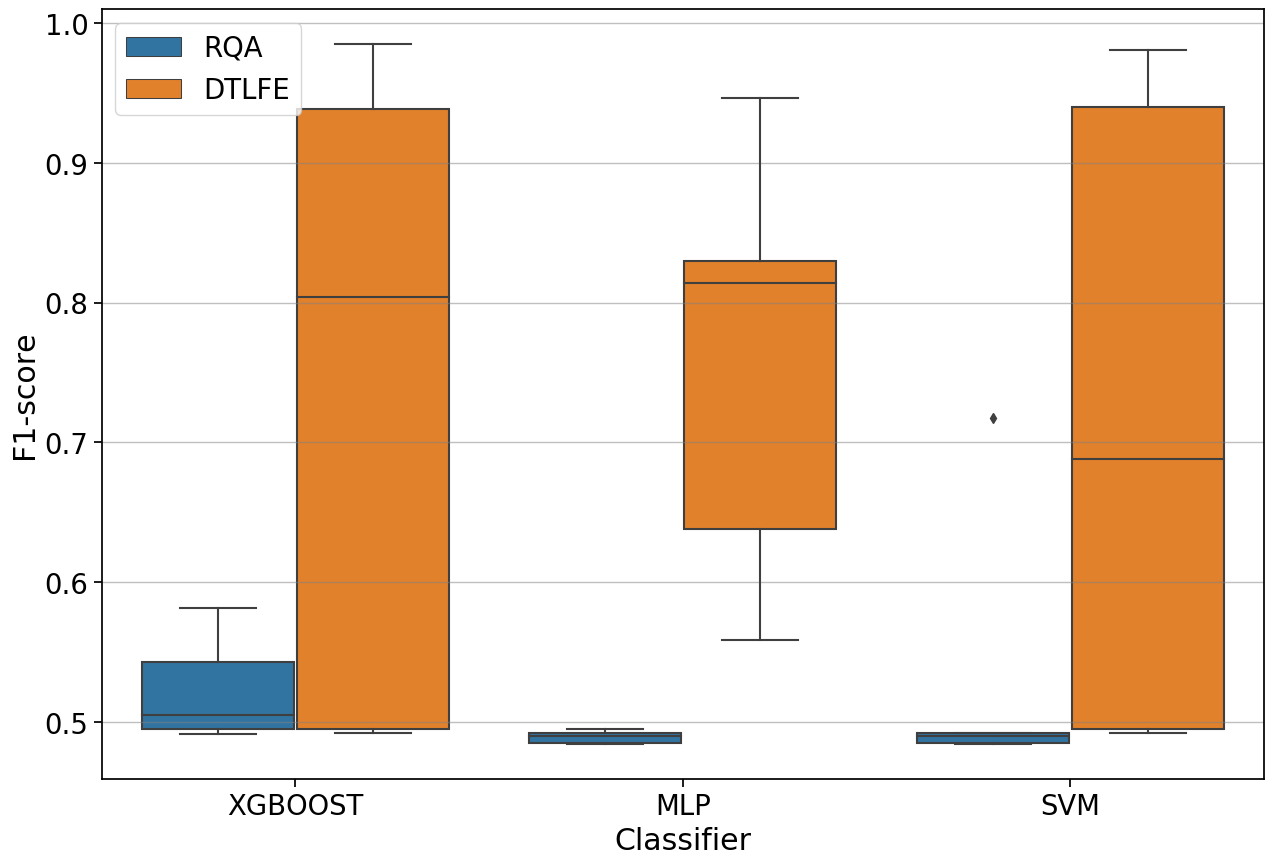

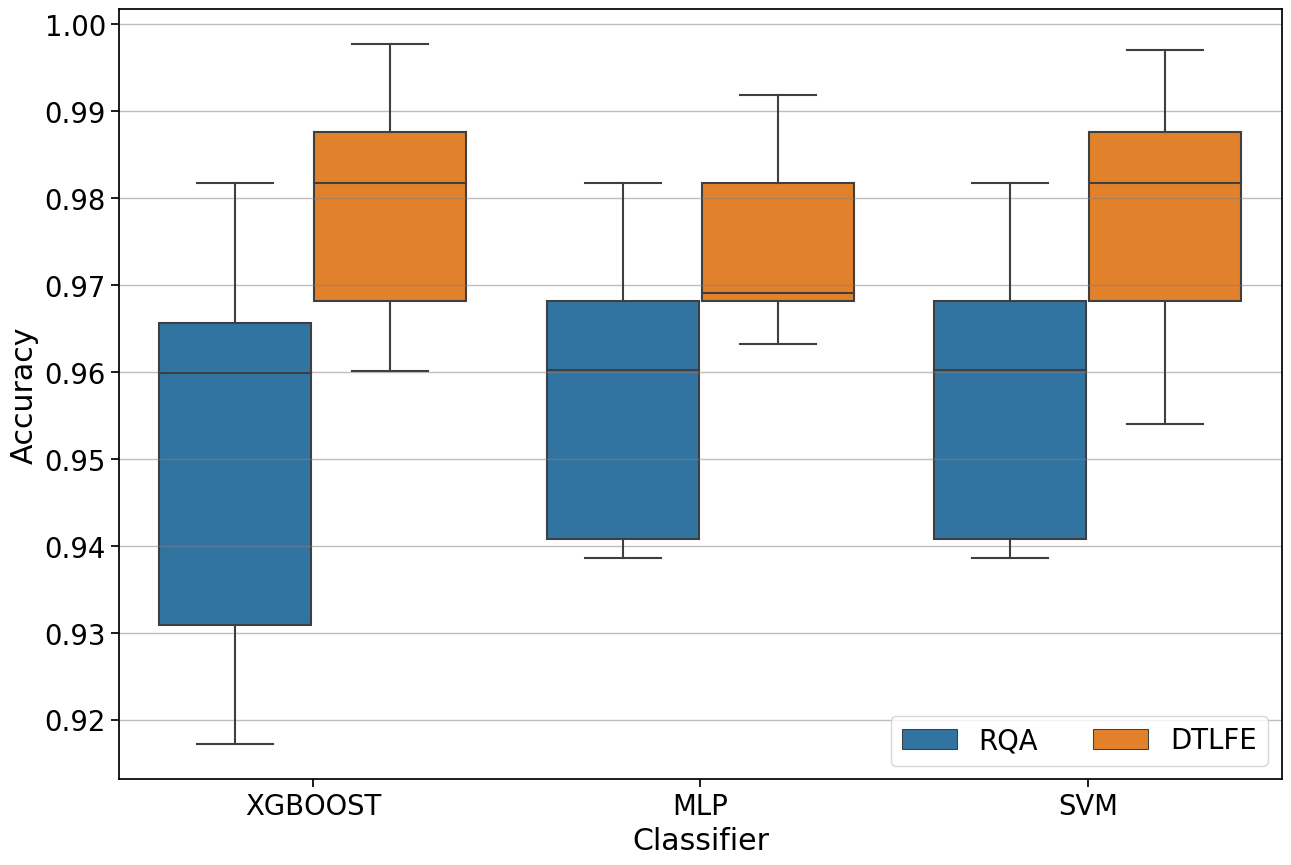

In [109]:
for b in ['treino','teste']:
    print(f"RQA vs. DLAFE (base de {b}) - Comparativo de Classificadores")
    
    df_ = df.query(f"base == '{b}'").reset_index()

    df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
    df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 
    
#     fig = plt.figure(figsize=(20,8));
#     df_.boxplot(by=['feature', 'classifier'], column=['f1', 'acc'], rot=90, figsize=(15,5));
#     plt.suptitle(f"RQA vs. DLAFE (base de {b})");
#     plt.show();
    
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(x="classifier", y="f1",
                hue="feature", order=["XGBOOST","MLP","SVM"],
                data=df_[df_['classifier']!='CNN'], 
                ax=ax, 
                # palette=sns_palette
               )
    ax.set(xlabel='Classifier', ylabel='F1-score')
    ax.legend(frameon=True, loc='best', ncol=1);    
    plt.show()
    fig.savefig(
        os.path.join(
            caminho_imagens_notebook,
            f'2_classificadores_{b}_f1.png', 
        ),
        format='png', 
        dpi=300,
        bbox_inches='tight', 
        pad_inches=0
    )
    
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.boxplot(x="classifier", y="acc",
                hue="feature", order=["XGBOOST","MLP","SVM"],
                data=df_[df_['classifier']!='CNN'], 
                ax=ax, 
                # palette=sns_palette
               )
    ax.set(xlabel='Classifier', ylabel='Accuracy')
    ax.legend(frameon=True, loc='best', ncol=2);  
    # plt.suptitle(f"RQA vs. DLAFE (base de {b}) - Comparativo de Classificadores");
    plt.show();

    fig.savefig(
        os.path.join(
            caminho_imagens_notebook,
            f'2_classificadores_{b}_acuracia.png', 
        ),
        format='png', 
        dpi=300,
        bbox_inches='tight', 
        pad_inches=0
    )

    # fig.savefig(
    #     'D:/Users/diego/MEGA/Pesquisa/Papers/IEEE PES GM 2021/destination_path.jpg', 
    #     format='jpg',
    #     dpi=300,
    #     bbox_inches='tight', pad_inches=0

    # )

**CONCLUSÕES PARCIAIS:** 

...

### Desempenho por Aparelho

dish_washer - 9 (base de treino)


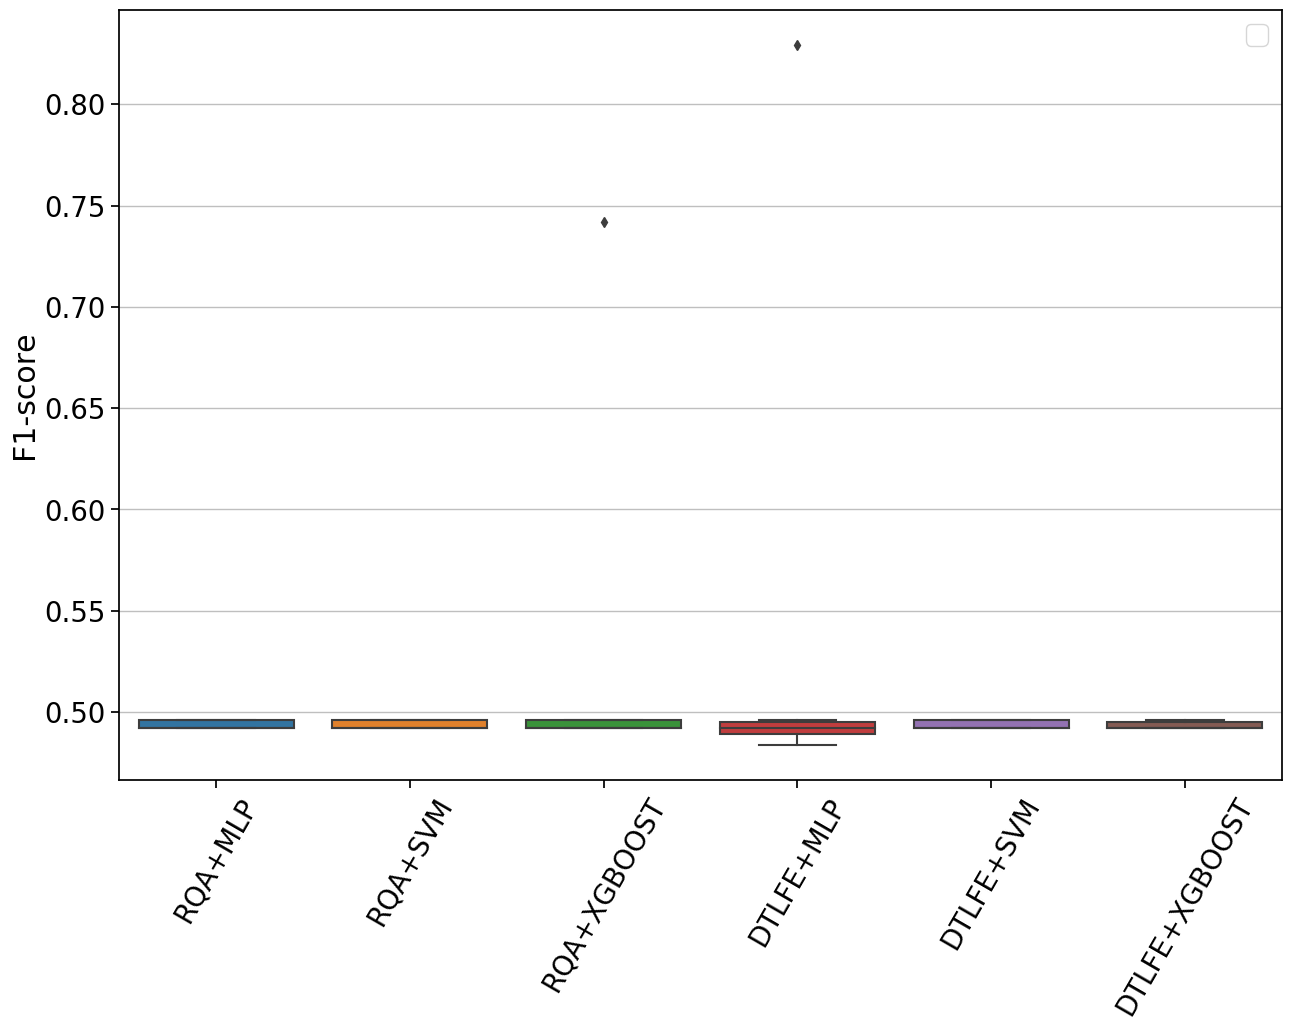

dish_washer - 9 (base de teste)


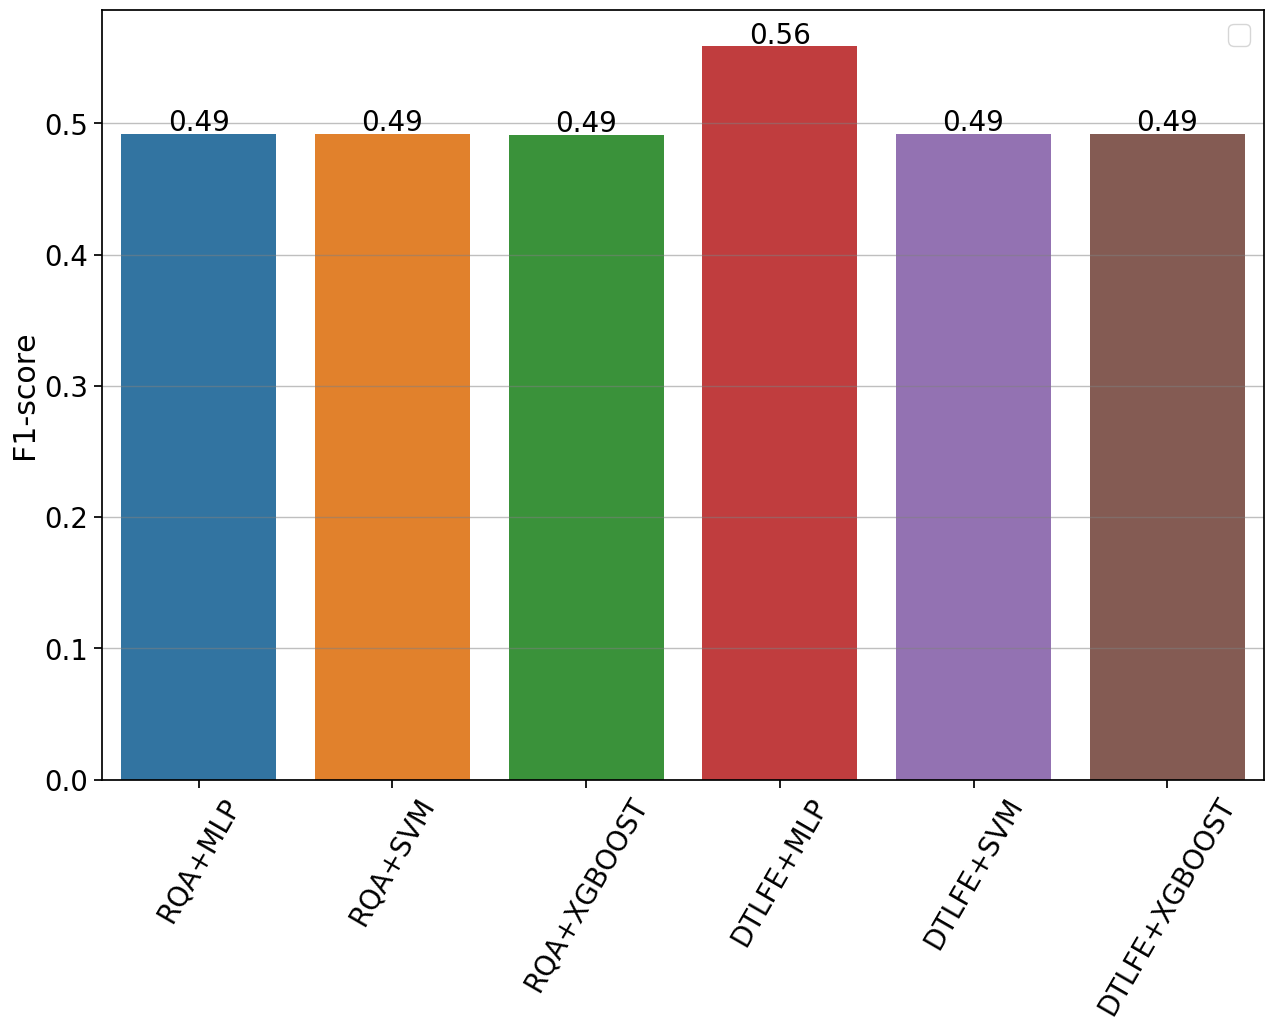

fridge - 7 (base de treino)


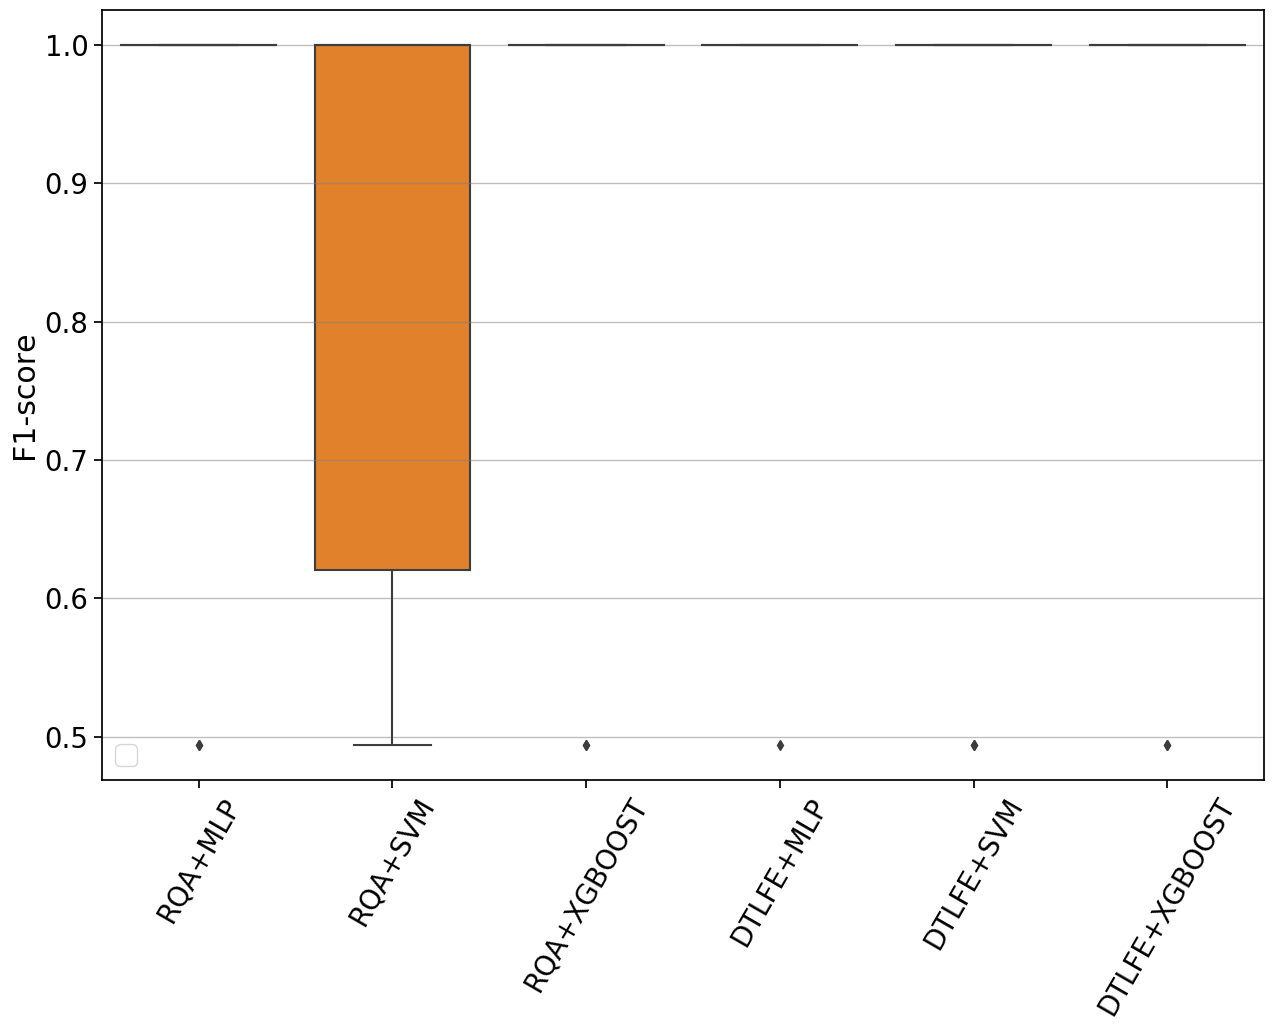

fridge - 7 (base de teste)


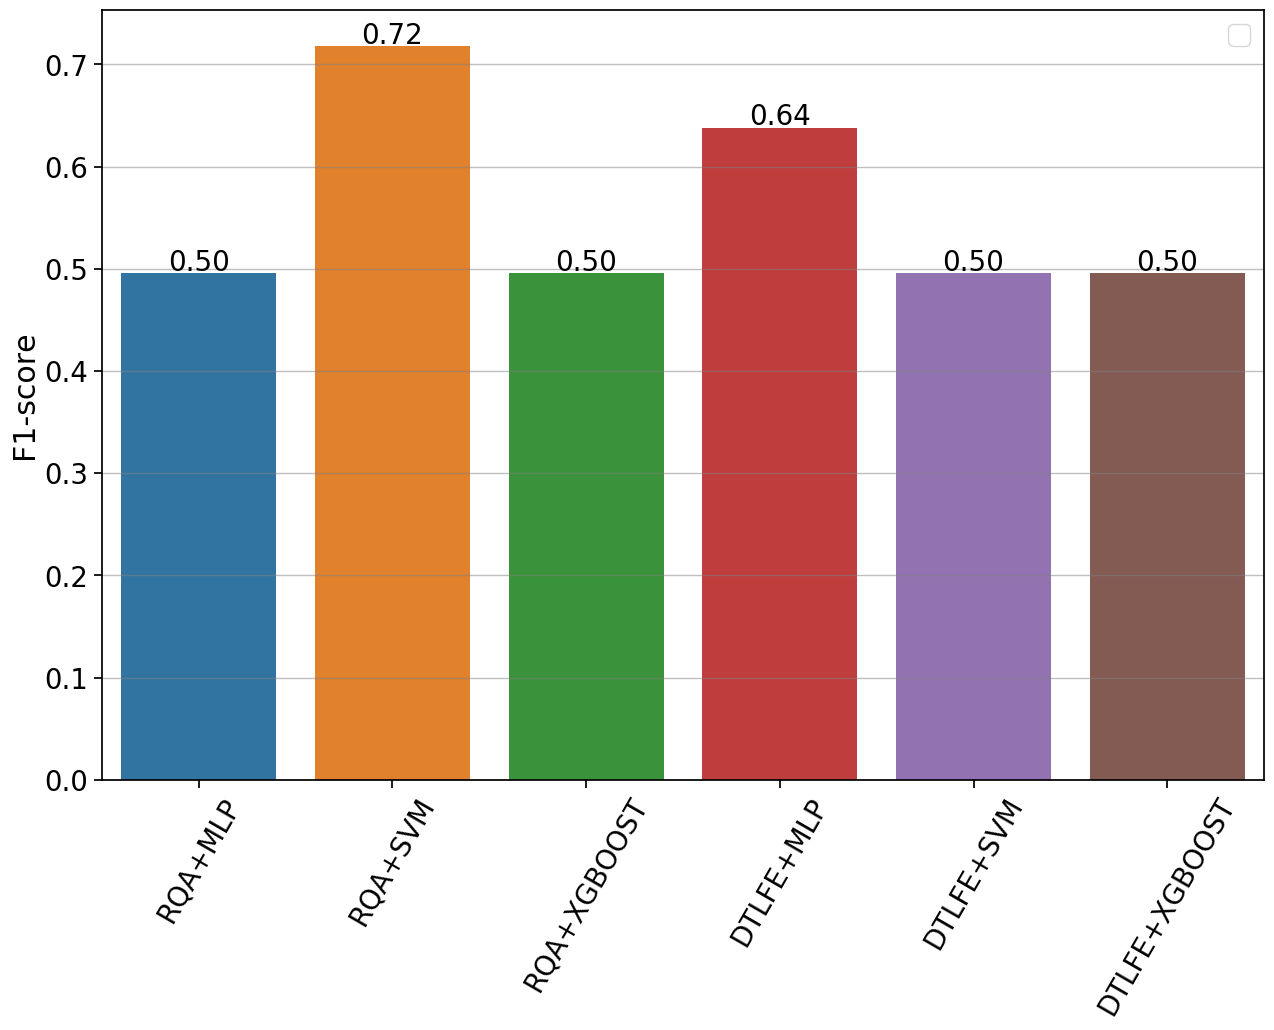

microwave - 16 (base de treino)


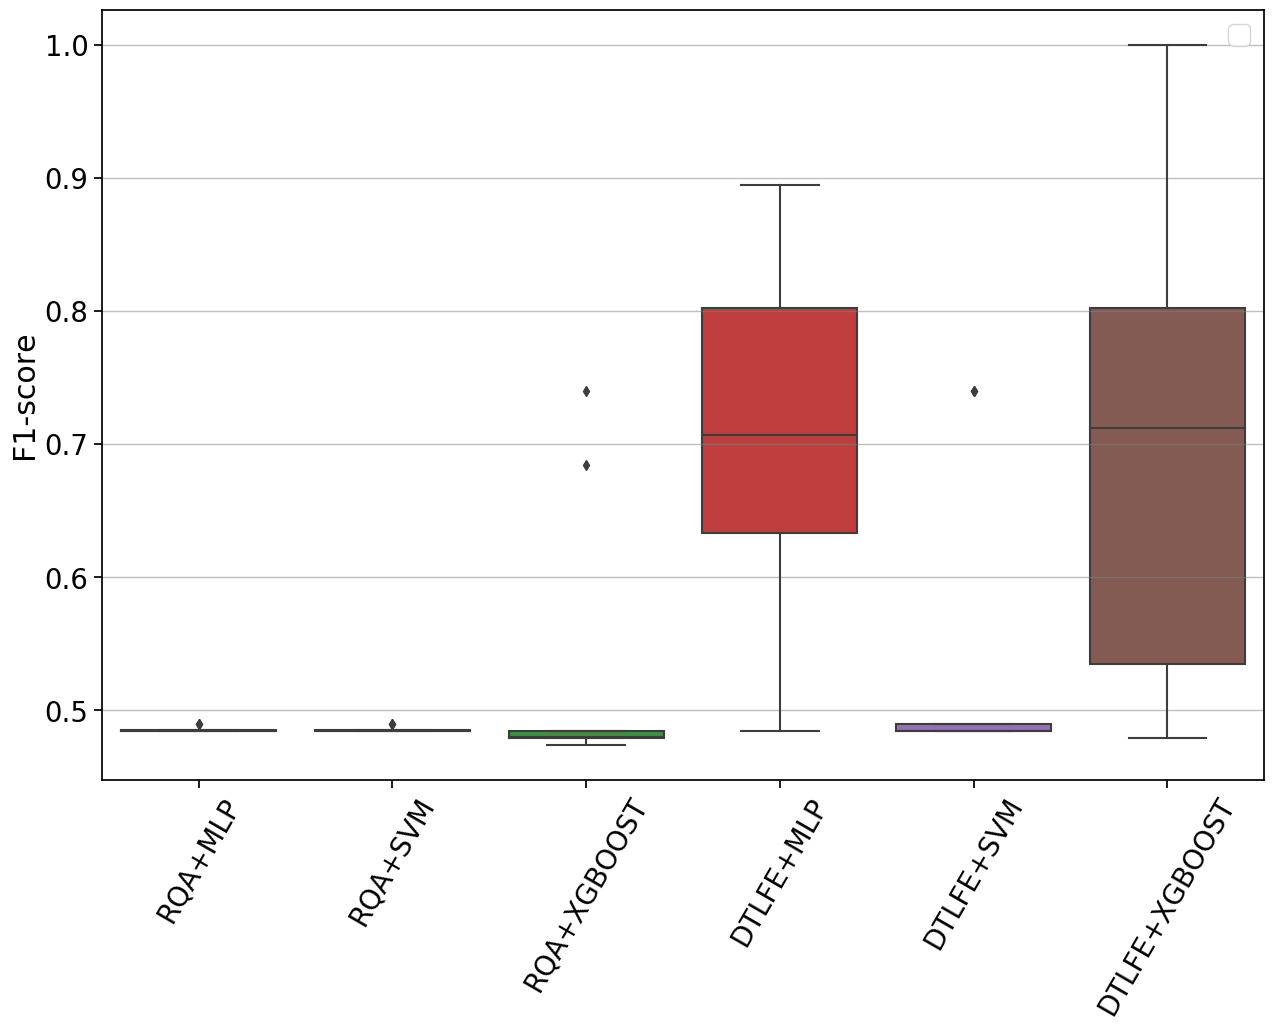

microwave - 16 (base de teste)


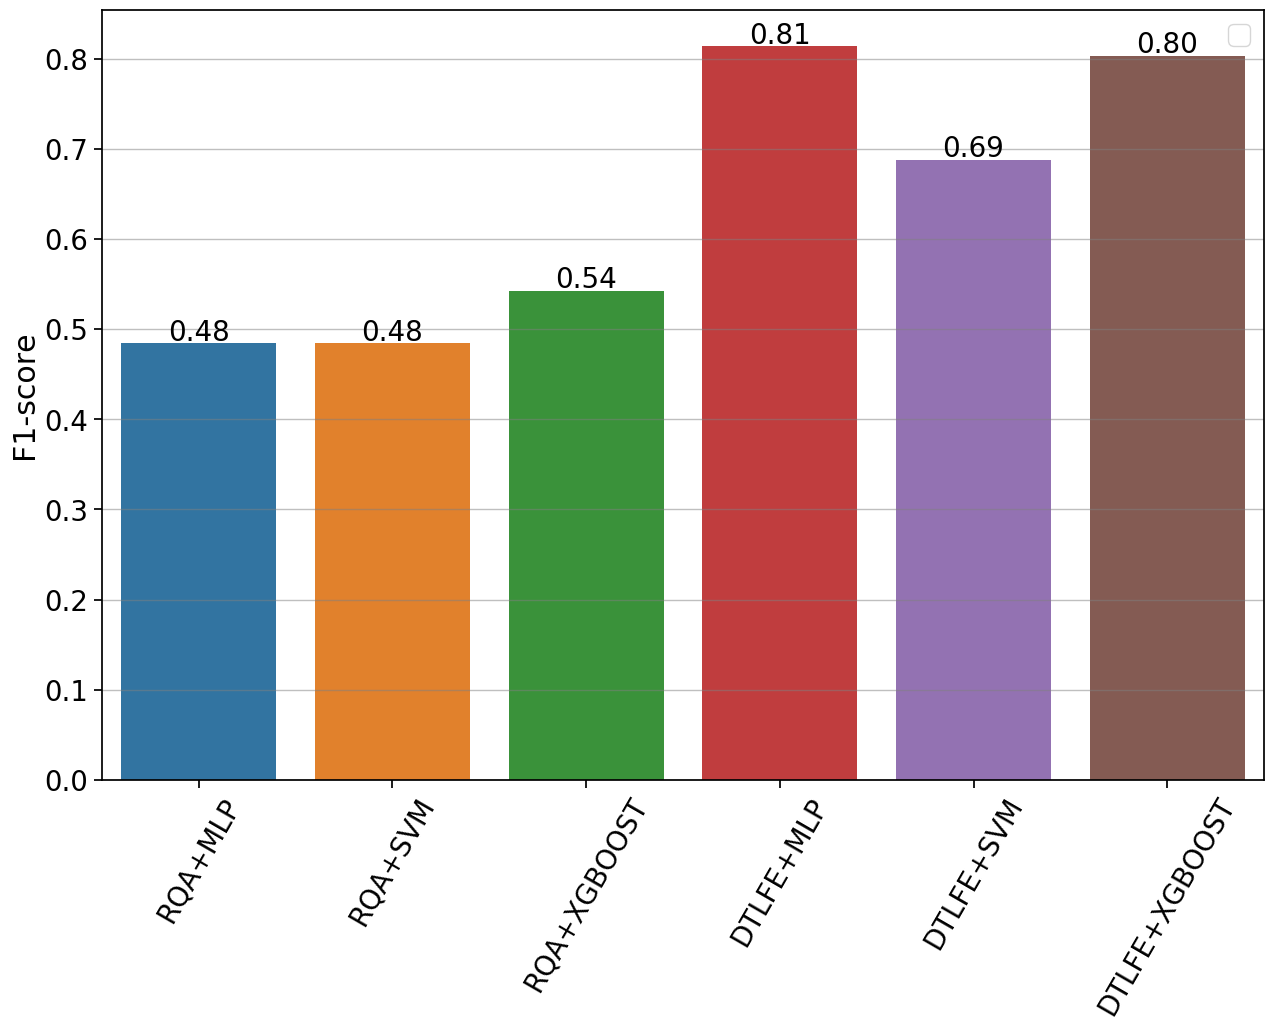

washer_dryer - 13 (base de treino)


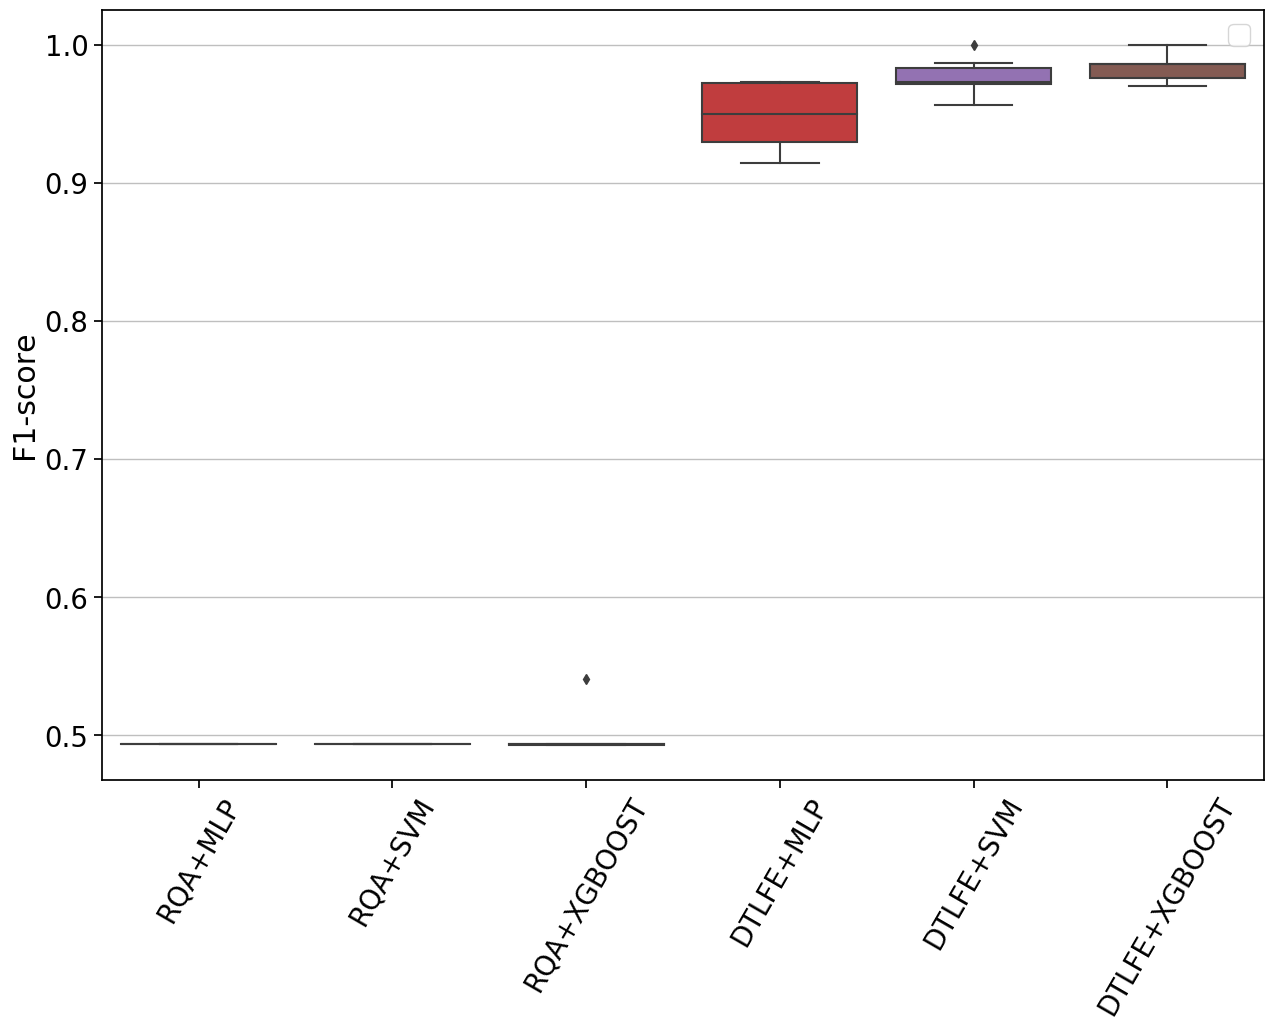

washer_dryer - 13 (base de teste)


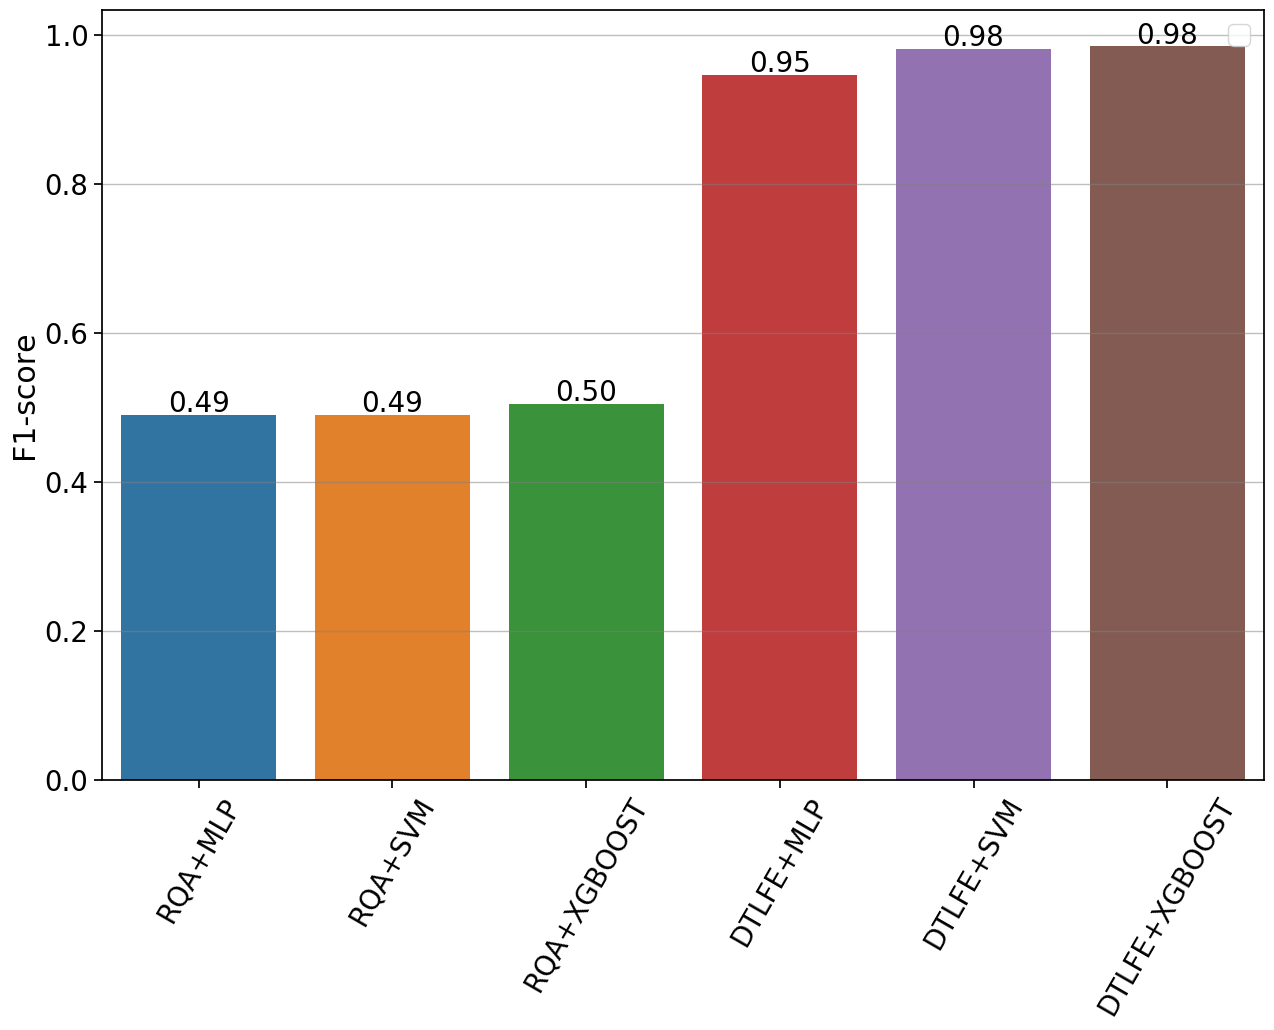

washer_dryer - 14 (base de treino)


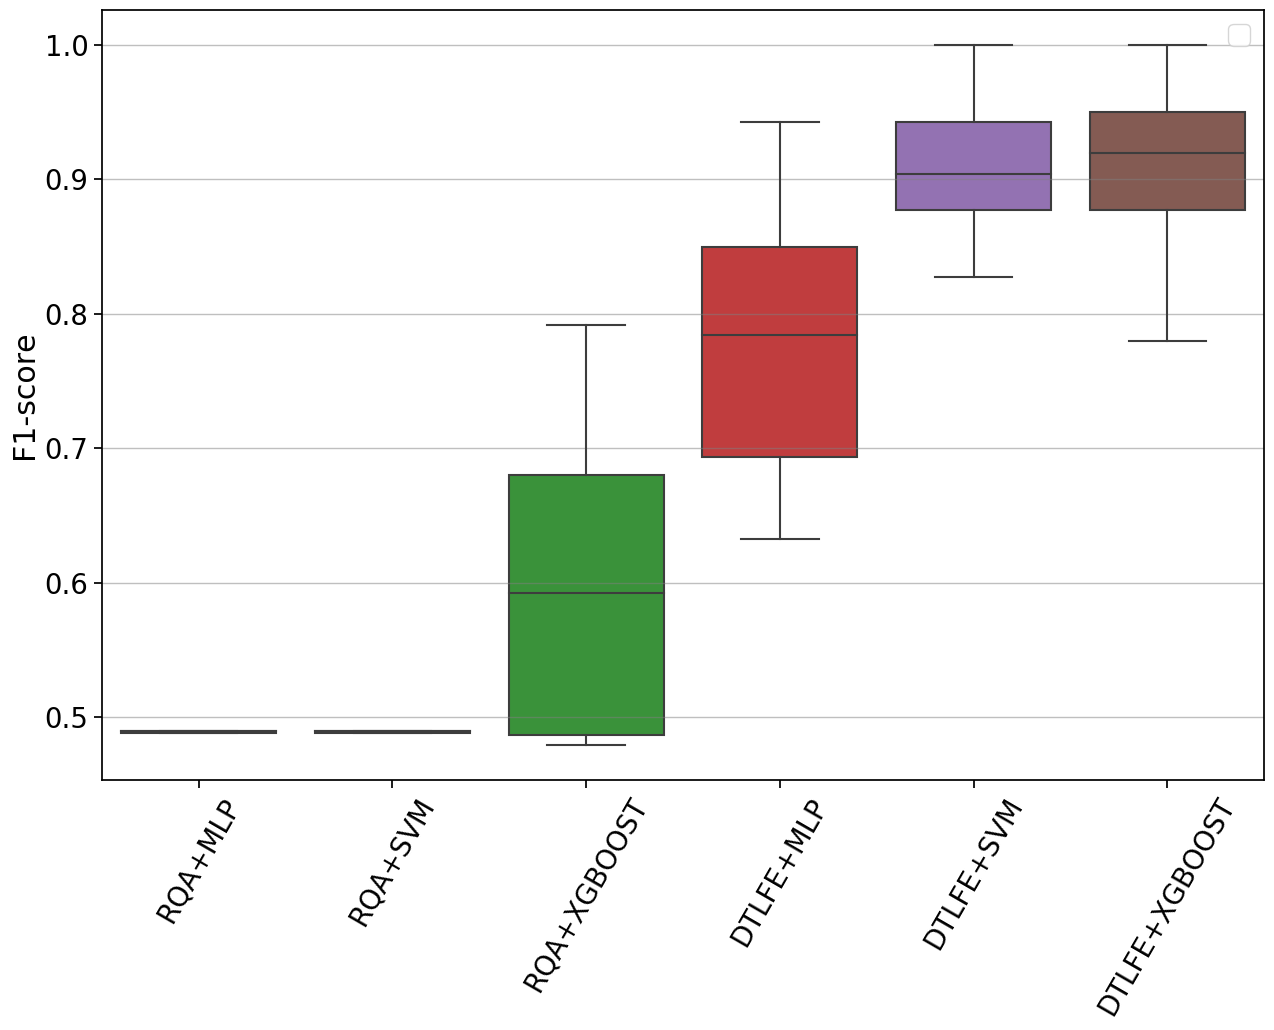

washer_dryer - 14 (base de teste)


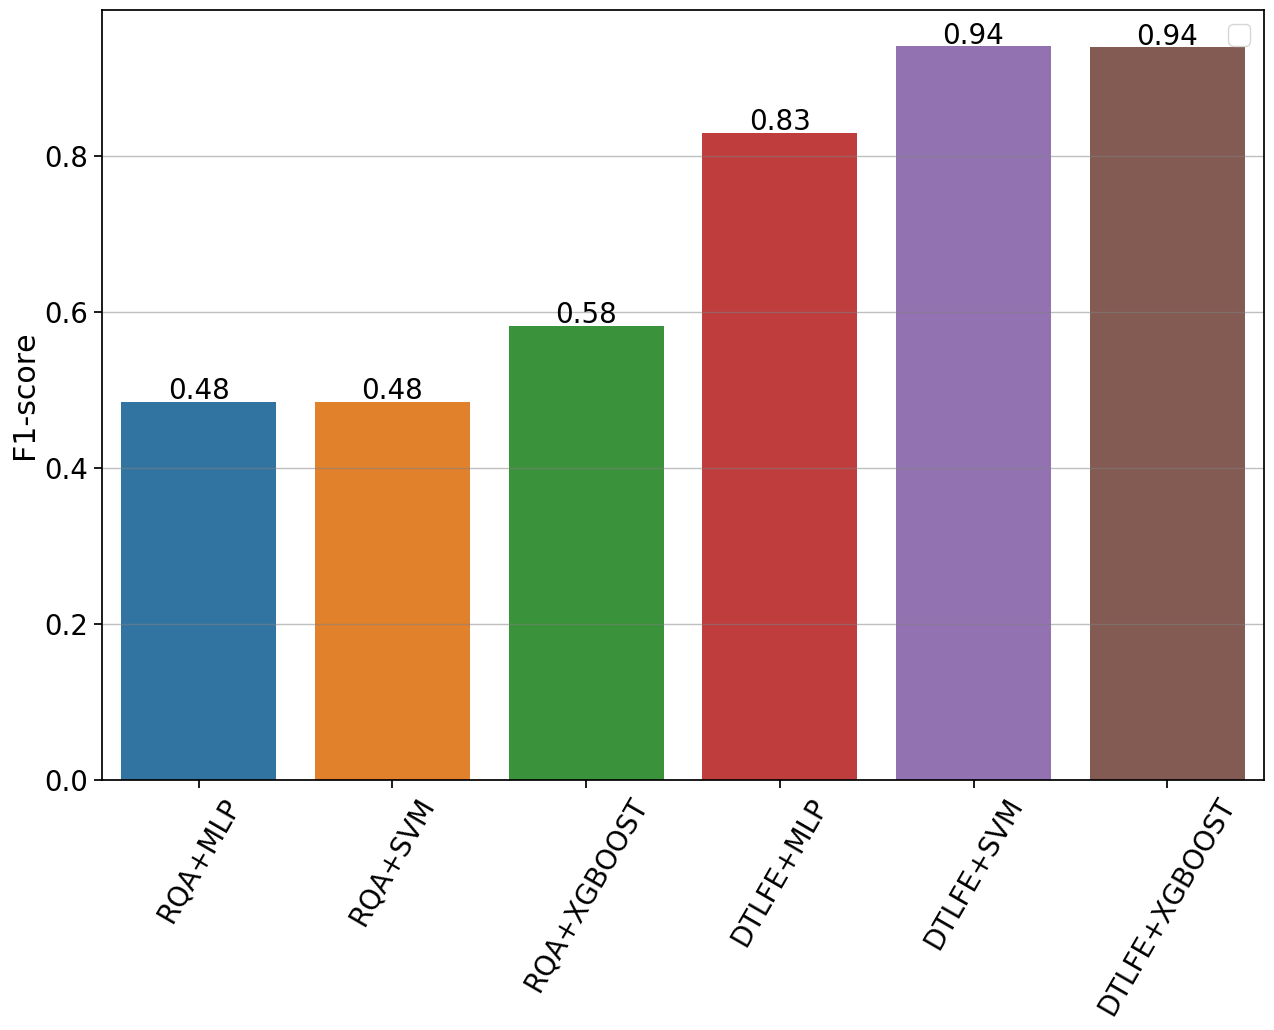

In [112]:
for a in df['appliance'].unique():
    
    #fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    for i, b in enumerate(['treino','teste']):

        df_ = df.query(f"appliance == '{a}' and base == '{b}'").reset_index()

        df_['feature'] = df_['method'].apply(lambda m: m.split('+')[0])
        df_['classifier'] = df_['method'].apply(lambda m: m.split('+')[1]) 

    #     fig = plt.figure(figsize=(20,8));
    #     df_.boxplot(by=['feature', 'classifier'], column=['f1', 'acc'], rot=90, figsize=(15,5));
    #     plt.suptitle(f"RQA vs. DLAFE (base de {b})");
    #     plt.show();
        
        print(f"{a} (base de {b})")
        fig, ax = plt.subplots(figsize=(15, 10))
        
        if b == 'treino':
            sns.boxplot(x="method", y="f1", #order=["XGBOOST","MLP","SVM"],
                        data=df_[df_['classifier']!='CNN'], 
                        ax=ax)
        else:
            g=sns.barplot(x="method", y="f1", #order=["XGBOOST","MLP","SVM"],
                        data=df_[df_['classifier']!='CNN'], 
                        ax=ax)
            # Inserting metrics over the bars
            for bar in g.patches:
                g.annotate(format(bar.get_height(), '.2f'), 
                (bar.get_x() + bar.get_width() / 2, 
                bar.get_height()), ha='center', va='center',
                size=20, xytext=(0, 8),
                textcoords='offset points')

        ax.set(xlabel='', ylabel='F1-score')#, title=f'F1-Score (base de {b})')
        ax.legend({});#frameon=False, loc='best', ncol=2); 

            #         sns.boxplot(x="appliance", y="acc",
#                     hue="method", #order=["XGBOOST","MLP","SVM"],
#                     data=df_[df_['classifier']!='CNN'], 
#                     ax=axes[1])
#         axes[1].set(xlabel='Appliance', ylabel='F1-score', title='Accuracy')
#         axes[1].legend(frameon=False, loc='best', ncol=2);  

        for tick in ax.get_xticklabels():
            tick.set_rotation(60);
        # plt.suptitle(f"{a} (base de {b})");
        plt.show()

        fig.savefig(
            os.path.join(
                caminho_imagens_notebook,
                f'3_aparelho_{a}_{b}_f1.png', 
            ),
            format='png', 
            dpi=300,
            bbox_inches='tight', 
            pad_inches=0
        )
        
#     plt.show();
    

# Conclusões

In [57]:
# ...

...

# Fim.

In [113]:
%load_ext watermark

In [114]:
%watermark -a "Diego Luiz Cavalca" -u -n -t -z -v -m -g

Author: Diego Luiz Cavalca

Last updated: Sat Jun 05 2021 12:42:49Hora oficial do Brasil

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

Compiler    : MSC v.1928 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: dfd0b9e1b7c89909ffb50dc1fd9e736294579e58

